In [6]:
pip install keras-tuner

     |████████████████████████████████| 129 kB 22.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.losses import Huber
from keras_tuner import HyperModel, RandomSearch

# Load the CSV file into a DataFrame
DataCapstone = pd.read_csv('DataCapstone.csv', delimiter=';', decimal=',')

# Select relevant features using the given column names
btc_col = 'BITCOIN PRICE IN USD'
eth_col = 'ETHEREUM PRICE IN USD'
sp500_col = 'S&P 500 PRICE IN USD'
gold_col = 'GOLD PRICE IN USD'
features = [btc_col, eth_col, sp500_col, gold_col]

# Calculate returns as log differences
def calculate_returns(prices):
    return np.log(prices / prices.shift(1)).dropna()

returns_data = DataCapstone[features].apply(calculate_returns)

# Normalize the returns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(returns_data)

# Convert to supervised format
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length][:2])  # Only Bitcoin and Ethereum returns as targets
    return np.array(x), np.array(y)

# Define sequence length
SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data into training and test sets
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {x_train.shape}, Test samples: {x_test.shape}")

# Custom evaluation metric
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.where(y_true == 0, np.nan, y_true)  # Avoid division by zero
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

# Define a function to build the LSTM model
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units1', min_value=32, max_value=256, step=32),
                       return_sequences=True, input_shape=(SEQ_LENGTH, len(features))))
        model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(LSTM(units=hp.Int('units2', min_value=32, max_value=256, step=32)))
        model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(2))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                      loss=Huber(),
                      metrics=['mean_absolute_error'])
        return model

# Initialize the hypermodel
hypermodel = MyHyperModel()

# Setup the tuner
tuner = RandomSearch(hypermodel,
                     objective='val_mean_absolute_error',
                     max_trials=20,
                     executions_per_trial=1,
                     directory='lstm_hyperparam_tuning',
                     project_name='bitcoin_eth_returns')

# Run the search
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=32)

# Retrieve the best model and parameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(f"Units1: {best_hyperparameters.get('units1')}")
print(f"Units2: {best_hyperparameters.get('units2')}")
print(f"Dropout1: {best_hyperparameters.get('dropout1')}")
print(f"Dropout2: {best_hyperparameters.get('dropout2')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

# Evaluate the best model
loss, mae = best_model.evaluate(x_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

# Predict on test data
predictions = best_model.predict(x_test)

# Inverse transform predictions and actual values to their original scale
y_test_inv = scaler.inverse_transform(np.concatenate([y_test, np.zeros((len(y_test), len(features) - 2))], axis=1))[:, :2]
predictions_inv = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), len(features) - 2))], axis=1))[:, :2]

btc_actual = y_test_inv[:, 0]
eth_actual = y_test_inv[:, 1]
btc_predictions = predictions_inv[:, 0]
eth_predictions = predictions_inv[:, 1]

btc_mae = mean_absolute_error(btc_actual, btc_predictions)
btc_mape = mean_absolute_percentage_error(btc_actual, btc_predictions)
btc_r2 = r2_score(btc_actual, btc_predictions)

eth_mae = mean_absolute_error(eth_actual, eth_predictions)
eth_mape = mean_absolute_percentage_error(eth_actual, eth_predictions)
eth_r2 = r2_score(eth_actual, eth_predictions)

# Print evaluation metrics
print("\nBitcoin Prediction Metrics:")
print(f"Mean Absolute Error: {btc_mae}")
print(f"Mean Absolute Percentage Error: {btc_mape}%")
print(f"R-squared Score: {btc_r2}")

print("\nEthereum Prediction Metrics:")
print(f"Mean Absolute Error: {eth_mae}")
print(f"Mean Absolute Percentage Error: {eth_mape}%")
print(f"R-squared Score: {eth_r2}")

# Plot predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(btc_actual, label='Actual BITCOIN RETURNS')
plt.plot(btc_predictions, label='Predicted BITCOIN RETURNS')
plt.legend()
plt.xlabel('Time')
plt.ylabel('BITCOIN RETURNS')
plt.title('Bitcoin Returns Prediction')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(eth_actual, label='Actual ETHEREUM RETURNS')
plt.plot(eth_predictions, label='Predicted ETHEREUM RETURNS')
plt.legend()
plt.xlabel('Time')
plt.ylabel('ETHEREUM RETURNS')
plt.title('Ethereum Returns Prediction')
plt.show()

# Plot training and validation loss
history = best_model.history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

Trial 13 Complete [00h 02m 30s]
val_mean_absolute_error: 0.4595571458339691

Best val_mean_absolute_error So Far: 0.4574694335460663
Total elapsed time: 00h 45m 33s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
64                |64                |units1
0.5               |0.3               |dropout1
64                |160               |units2
0.3               |0.1               |dropout2
0.001638          |0.0041055         |learning_rate

Epoch 1/50
33/33 [==============================] - 7s 122ms/step - loss: 0.4041 - mean_absolute_error: 0.7392 - val_loss: 0.1913 - val_mean_absolute_error: 0.4592
Epoch 2/50
33/33 [==============================] - 3s 92ms/step - loss: 0.4014 - mean_absolute_error: 0.7349 - val_loss: 0.1920 - val_mean_absolute_error: 0.4601
Epoch 3/50
33/33 [==============================] - 3s 94ms/step - loss: 0.4000 - mean_absolute_error: 0.7321 - val_loss: 0.1923 - val_mean_absolute_error: 0.4586
Epoch 4/50
33/33 [=========

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Training samples: (1052, 60, 4), Test samples: (263, 60, 4)
Epoch 1/50
33/33 [==============================] - 7s 139ms/step - loss: 0.4045 - val_loss: 0.1931
Epoch 2/50
33/33 [==============================] - 4s 111ms/step - loss: 0.4021 - val_loss: 0.1940
Epoch 3/50
33/33 [==============================] - 4s 110ms/step - loss: 0.4000 - val_loss: 0.1929
Epoch 4/50
33/33 [==============================] - 4s 109ms/step - loss: 0.4006 - val_loss: 0.1917
Epoch 5/50
33/33 [==============================] - 4s 110ms/step - loss: 0.3995 - val_loss: 0.1928
Epoch 6/50
33/33 [==============================] - 4s 109ms/step - loss: 0.3966 - val_loss: 0.2018
Epoch 7/50
33/33 [==============================] - 4s 108ms/step - loss: 0.3974 - val_loss: 0.1936
Epoch 8/50
33/33 [==============================] - 4s 112ms/step - loss: 0.3918 - val_loss: 0.1911
Epoch 9/50
33/33 [==============================] - 4s 110ms/step - loss: 0.3910 - val_loss: 0.1925
Epoch 10/50
33/33 [=====================

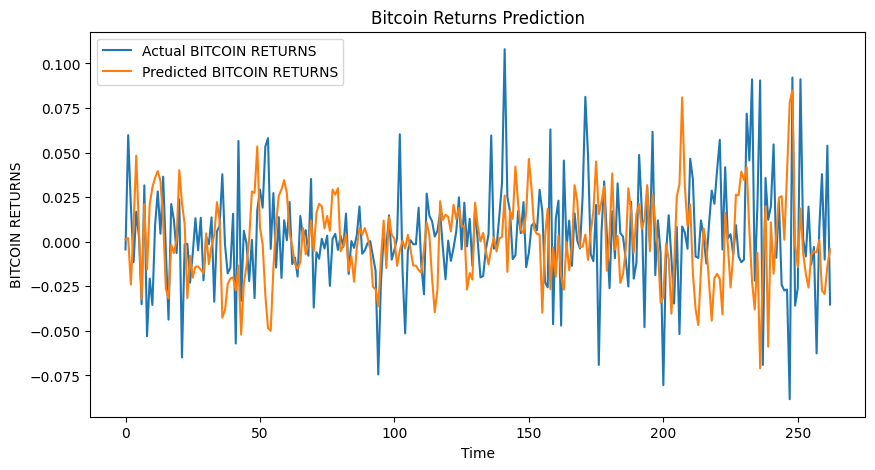

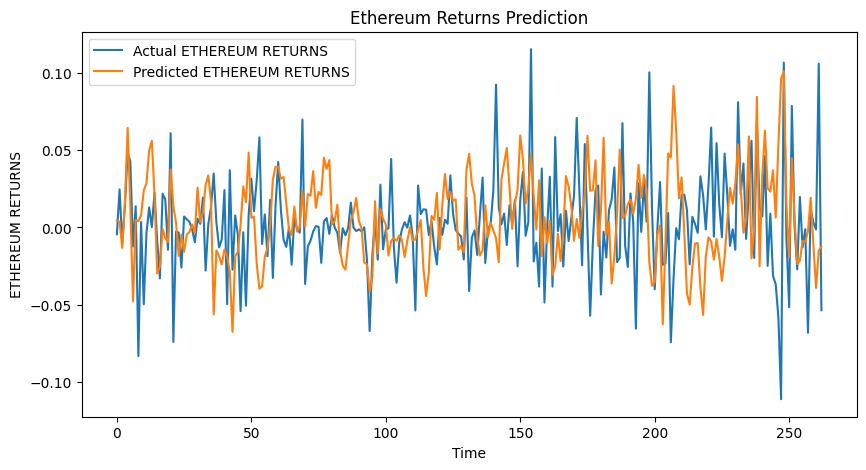

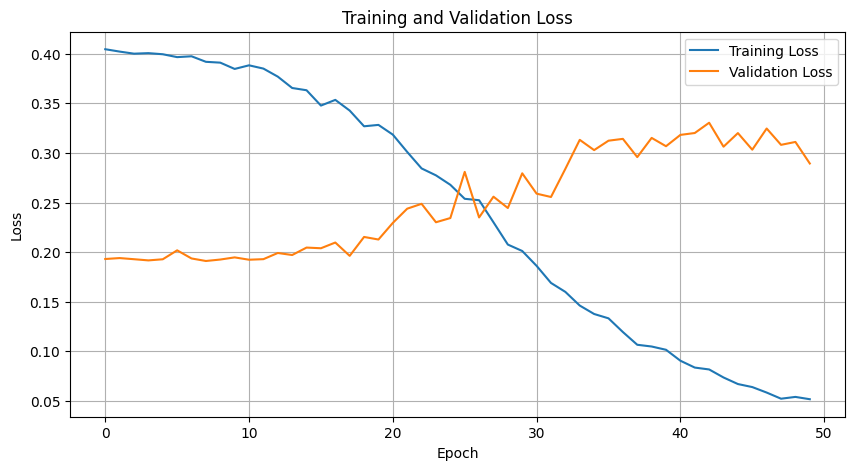

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, r2_score

# Load the CSV file into a DataFrame
DataCapstone = pd.read_csv('DataCapstone.csv', delimiter=';', decimal=',')

# Select relevant features using the given column names
btc_col = 'BITCOIN PRICE IN USD'
eth_col = 'ETHEREUM PRICE IN USD'
sp500_col = 'S&P 500 PRICE IN USD'
gold_col = 'GOLD PRICE IN USD'
features = [btc_col, eth_col, sp500_col, gold_col]

# Calculate returns as log differences
def calculate_returns(prices):
    return np.log(prices / prices.shift(1)).dropna()

returns_data = DataCapstone[features].apply(calculate_returns)

# Normalize the returns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(returns_data)

# Convert to supervised format
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length][:2])  # Only Bitcoin and Ethereum returns as targets
    return np.array(x), np.array(y)

# Define sequence length
SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data into training and test sets
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {x_train.shape}, Test samples: {x_test.shape}")

# Custom evaluation metric
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.where(y_true == 0, np.nan, y_true)  # Avoid division by zero
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

# Build the LSTM model with the best hyperparameters
best_units1 = 64
best_dropout1 = 0.3
best_units2 = 160
best_dropout2 = 0.1
best_learning_rate = 0.0041055

model = Sequential([
    LSTM(best_units1, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    Dropout(best_dropout1),
    LSTM(best_units2),
    Dropout(best_dropout2),
    Dense(2)  # Predict Bitcoin and Ethereum returns only
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate), loss='huber_loss')

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model
loss = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")

# Predict on test data
predictions = model.predict(x_test)

# Inverse transform predictions and actual values to their original scale
y_test_inv = scaler.inverse_transform(np.concatenate([y_test, np.zeros((len(y_test), len(features) - 2))], axis=1))[:, :2]
predictions_inv = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), len(features) - 2))], axis=1))[:, :2]

btc_actual = y_test_inv[:, 0]
eth_actual = y_test_inv[:, 1]
btc_predictions = predictions_inv[:, 0]
eth_predictions = predictions_inv[:, 1]

btc_mae = mean_absolute_error(btc_actual, btc_predictions)
btc_mape = mean_absolute_percentage_error(btc_actual, btc_predictions)
btc_r2 = r2_score(btc_actual, btc_predictions)

eth_mae = mean_absolute_error(eth_actual, eth_predictions)
eth_mape = mean_absolute_percentage_error(eth_actual, eth_predictions)
eth_r2 = r2_score(eth_actual, eth_predictions)

# Print evaluation metrics
print("\nBitcoin Prediction Metrics:")
print(f"Mean Absolute Error: {btc_mae}")
print(f"Mean Absolute Percentage Error: {btc_mape}%")
print(f"R-squared Score: {btc_r2}")

print("\nEthereum Prediction Metrics:")
print(f"Mean Absolute Error: {eth_mae}")
print(f"Mean Absolute Percentage Error: {eth_mape}%")
print(f"R-squared Score: {eth_r2}")

# Compare predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(btc_actual, label='Actual BITCOIN RETURNS')
plt.plot(btc_predictions, label='Predicted BITCOIN RETURNS')
plt.legend()
plt.xlabel('Time')
plt.ylabel('BITCOIN RETURNS')
plt.title('Bitcoin Returns Prediction')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(eth_actual, label='Actual ETHEREUM RETURNS')
plt.plot(eth_predictions, label='Predicted ETHEREUM RETURNS')
plt.legend()
plt.xlabel('Time')
plt.ylabel('ETHEREUM RETURNS')
plt.title('Ethereum Returns Prediction')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()